In [12]:
import numpy as np
import time as t
import os
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from matplotlib.ticker import FormatStrFormatter

In [13]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.
    ###设置图形尺寸，避免在 LaTeX 中缩放

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
            ###以点为单位的文档宽度，或预定文档类型的字符串
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
            ###您希望图形所占宽度的分数
    subplots: array-like, optional
            The number of rows and columns of subplots.
            ###子绘图的行数和列数。
    Returns
    -------
    fig_dim: tuple
            ### The primary difference is that we cannot modify a tuple once it is created.
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width
    ### 确定文档的类型从而选择生成图片区域的大小

    # Width of figure (in pts)
    # 图标在区域中占的宽度，并转换为英寸的单位
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2
    # 0.618

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)
# plt.rcParams.update()，其中 update 是 rcParams 对象的一个方法，用于更新 Matplotlib 的运行时配置参数。

In [14]:
# define the parameters
n = 1
R_max =1 # spatial distance
eps =1 # diffusion coefficient
final_time = 7
t_step = 0.0005
Max_step = int(final_time/t_step) # calculate the number of time steps
time = np.arange(0,final_time+t_step,t_step) 
time = time[1:]
time1 = time

# check the time step
# print("unit time step is:",time[1]-time[0],"\ntotal time steps:",len(time))

N =11
delta_r = (2*R_max)/(2*(N-1)+1)
# r = np.arange(0, N+1, 1, dtype=np.float32)
# r = r[1:]-0.5
# r = r*delta_r
r = np.arange(1, N+1, dtype=np.float64) # 生成左闭右开的范围，步长默认为1
r = (r- 1/2)*delta_r

lamda = 40*r**2

In [15]:
def coef_openloop(rl, eps, lam, tl, nn):
    N = len(rl)
    hr = rl[1]-rl[0]

    # 定义常数
    c1 = eps * tl / (2 * hr**2)
    c2 = eps * tl / (2 * hr)
    c3 = tl * lam / 2
    c4 = eps * tl * nn**2 / 2

    # 初始化系数矩阵的稀疏结构
    data_at = [1]
    column_at = [0]
    offset_at = [0]

    data_a = [1]
    column_a = [0]
    offset_a = [0]

    rrl = rl[1:-1]

    # 定义系数的坐标
    # I_m0 = np.arange(1, N-1) # 生成从第二个点到倒数第二个点的坐标 对角线
    # I_l0 = np.arange(0, N-2) # for i-1
    # I_r0 = np.arange(2,N) # for i+1

    #构建At矩阵系数
    At_1 = -(c1 * np.ones(N-2)) + c2 / rrl   # for i-1
    At_2 = (1 + 2 * c1) * np.ones(N-2) - c2 / rrl - c3[1:-1] + c4 / (rrl**2)  # for i
    At_3 = -c1 * np.ones(N-2)

    #对于每一行，记录非零元素的列索引和对应值
    for i in range(1,N-1):
        # 记录行偏移位置
        offset_at.append(len(data_at))
        # 第一部分下对角线
        data_at.append(At_1[i-1])
        column_at.append(i-1)

        # 第二部分对角线
        data_at.append(At_2[i-1])
        column_at.append(i)

        # 第三部分上对角线
        data_at.append(At_3[i-1])
        column_at.append(i+1)
    
    # 定义边界条件
    offset_at.append(len(data_at)) # 最后一行的第一个元素是即将添加的第一个元素，该元素在data中的索引为data的长度。data长度为n则下一个元素的索引为n(实际为第n+1的元素)
    data_at.append(1)
    column_at.append(N-1)
    offset_at.append(len(data_at)) # 行偏移向量中的最后一个元素是非零元素的个数

    # 构建At矩阵
    At = csr_matrix((data_at, column_at, offset_at), shape=(N, N))

    # 构建A矩阵系数
    A_1 = c1 * np.ones(N-2) - c2 / rrl
    A_2 = (1 - 2 * c1) * np.ones(N-2) + c2 / rrl + c3[1:-1] - c4 / (rrl**2)
    A_3 = c1 * np.ones(N-2)

    #对于每一行，记录非零元素的列索引和对应值
    for i in range(1,N-1):
        # 记录行偏移位置
        offset_a.append(len(data_a))
        # 第一部分下对角线
        data_a.append(A_1[i-1])
        column_a.append(i-1)

        # 第二部分对角线
        data_a.append(A_2[i-1])
        column_a.append(i)

        # 第三部分上对角线
        data_a.append(A_3[i-1])
        column_a.append(i+1)
    
    # 定义边界条件
    offset_a.append(len(data_a)) # 最后一行的第一个元素是即将添加的第一个元素，该元素在data中的索引为data的长度。data长度为n则下一个元素的索引为n(实际为第n+1的元素)
    data_a.append(1)
    column_a.append(N-1)
    offset_a.append(len(data_a)) # 行偏移向量中的最后一个元素是非零元素的个数

    A = csr_matrix((data_a, column_a, offset_a), shape=(N, N))

    # print("data_at:", data_at)
    # print("column_at:", column_at)
    # print("offset_at:", offset_at)


    return(At, A)
    # return(len(data_at), len(column_at), offset_at)

# # 测试用例
# rl = np.linspace(0, 10, 11)  # 假设网格点在 [0, 10] 区间
# eps = 1.0
# lam = 40*rl**2
# tl = 0.1
# nn = 2

# A, At= coef_openloop(rl, eps, lam, tl, nn)

# # 输出 At 和 A 矩阵的稀疏格式
# print("At matrix (CSR format):")
# print(At)
# print("\nA matrix (CSR format):")
# print(A)


In [16]:

def coef_openloop2(rl, eps, lam, tl, nn):
    N = len(rl)
    hr = rl[1]-rl[0]

    # 定义常数
    c1 = eps * tl / (2 * hr**2)
    c2 = eps * tl / (4 * hr)
    c3 = tl * lam / 2
    c4 = eps * tl * nn**2 / 2
    # 第一行系数
    a1 = 1 + 2 * c1 - c3[0] + 4 * c4 / (hr**2)
    a2 = - c1 - 2 * c2 / hr
    a3 = 1 - 2 * c1 + c3[0] - 4 * c4 / (hr**2)
    a4 = c1 + 2 * c2 / hr

    # 初始化系数矩阵的稀疏结构
    data_at = [a1,a2]
    column_at = [0,1]
    offset_at = [0]

    data_a = [a3,a4]
    column_a = [0,1]
    offset_a = [0]

    rrl = rl[1:-1]

    # 定义系数的坐标
    # I_m0 = np.arange(1, N-1) # 生成从第二个点到倒数第二个点的坐标 对角线
    # I_l0 = np.arange(0, N-2) # for i-1
    # I_r0 = np.arange(2,N) # for i+1

    #构建At矩阵系数
    At_1 = -(c1 * np.ones(N-2)) + c2 / rrl   # for i-1
    At_2 = (1 + 2 * c1) * np.ones(N-2) - c3[1:-1] + c4 / (rrl**2)  # for i
    At_3 = -c1 * np.ones(N-2) - c2 / rrl 

    #对于每一行，记录非零元素的列索引和对应值
    for i in range(1,N-1):
        # 记录行偏移位置
        offset_at.append(len(data_at))
        # 第一部分下对角线
        data_at.append(At_1[i-1])
        column_at.append(i-1)

        # 第二部分对角线
        data_at.append(At_2[i-1])
        column_at.append(i)

        # 第三部分上对角线
        data_at.append(At_3[i-1])
        column_at.append(i+1)
    
    # 定义边界条件
    offset_at.append(len(data_at)) # 最后一行的第一个元素是即将添加的第一个元素，该元素在data中的索引为data的长度。data长度为n则下一个元素的索引为n(实际为第n+1的元素)
    data_at.append(1)
    column_at.append(N-1)
    offset_at.append(len(data_at)) # 行偏移向量中的最后一个元素是非零元素的个数

    # 构建At矩阵
    At = csr_matrix((data_at, column_at, offset_at), shape=(N, N))

    # 构建A矩阵系数
    A_1 = c1 * np.ones(N-2) - c2 / rrl
    A_2 = (1 - 2 * c1) * np.ones(N-2) + c2 / rrl + c3[1:-1] - c4 / (rrl**2)
    A_3 = c1 * np.ones(N-2)

    #对于每一行，记录非零元素的列索引和对应值
    for i in range(1,N-1):
        # 记录行偏移位置
        offset_a.append(len(data_a))
        # 第一部分下对角线
        data_a.append(A_1[i-1])
        column_a.append(i-1)

        # 第二部分对角线
        data_a.append(A_2[i-1])
        column_a.append(i)

        # 第三部分上对角线
        data_a.append(A_3[i-1])
        column_a.append(i+1)
    
    # 定义边界条件
    offset_a.append(len(data_a)) # 最后一行的第一个元素是即将添加的第一个元素，该元素在data中的索引为data的长度。data长度为n则下一个元素的索引为n(实际为第n+1的元素)
    data_a.append(1)
    column_a.append(N-1)
    offset_a.append(len(data_a)) # 行偏移向量中的最后一个元素是非零元素的个数

    A = csr_matrix((data_a, column_a, offset_a), shape=(N, N))

    # print("data_at:", data_at)
    # print("column_at:", column_at)
    # print("offset_at:", offset_at)


    return(At, A)
    # return(len(data_at), len(column_at), offset_at)

# # 测试用例
# rl = np.linspace(0, 10, 11)  # 假设网格点在 [0, 10] 区间
# eps = 1.0
# lam = 40*rl**2
# tl = 0.1
# nn = 2

# A, At= coef_openloop(rl, eps, lam, tl, nn)

# 输出 At 和 A 矩阵的稀疏格式
# print("At matrix (CSR format):")
# print(At)
# print("\nA matrix (CSR format):")
# print(A)


At matrix (CSR format):
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 29 stored elements and shape (11, 11)>
  Coords	Values
  (0, 0)	1.0
  (1, 0)	-0.009187500000000001
  (1, 1)	1.0487959183673472
  (1, 2)	-0.027562500000000004
  (2, 1)	-0.016537500000000004
  (2, 2)	1.0479431065759637
  (2, 3)	-0.027562500000000004
  (3, 2)	-0.019687500000000004
  (3, 3)	1.048388888888889
  (3, 4)	-0.027562500000000004
  (4, 3)	-0.0214375
  (4, 4)	1.0485243764172338
  (4, 5)	-0.027562500000000004
  (5, 4)	-0.022551136363636367
  (5, 5)	1.0482810292160945
  (5, 6)	-0.027562500000000004
  (6, 5)	-0.02332211538461539
  (6, 6)	1.0477047827020356
  (6, 7)	-0.027562500000000004
  (7, 6)	-0.023887500000000002
  (7, 7)	1.0468379591836736
  (7, 8)	-0.027562500000000004
  (8, 7)	-0.024319852941176473
  (8, 8)	1.0457105528485904
  (8, 9)	-0.027562500000000004
  (9, 8)	-0.024661184210526318
  (9, 9)	1.0443431448294924
  (9, 10)	-0.027562500000000004
  (10, 10)	1.0

A matrix (CSR format):
<Compress

In [17]:
At, A= coef_openloop2(r, eps, lamda, t_step, n)

# 输出 At 和 A 矩阵的稀疏格式
print("At matrix (CSR format):")
print(At)
print("\nA matrix (CSR format):")
print(A)

At matrix (CSR format):
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 30 stored elements and shape (11, 11)>
  Coords	Values
  (0, 0)	1.1653523242630386
  (0, 1)	-0.05512500000000001
  (1, 0)	-0.018375000000000002
  (1, 1)	1.0671709183673472
  (1, 2)	-0.036750000000000005
  (2, 1)	-0.022050000000000004
  (2, 2)	1.0589681065759637
  (2, 3)	-0.03307500000000001
  (3, 2)	-0.023625000000000004
  (3, 3)	1.0562638888888891
  (3, 4)	-0.03150000000000001
  (4, 3)	-0.024500000000000004
  (4, 4)	1.0546493764172338
  (4, 5)	-0.030625000000000003
  (5, 4)	-0.025056818181818184
  (5, 5)	1.053292392852458
  (5, 6)	-0.030068181818181824
  (6, 5)	-0.025442307692307695
  (6, 6)	1.0519451673174203
  (6, 7)	-0.029682692307692313
  (7, 6)	-0.025725000000000005
  (7, 7)	1.0505129591836737
  (7, 8)	-0.029400000000000003
  (8, 7)	-0.02594117647058824
  (8, 8)	1.048953199907414
  (8, 9)	-0.02918382352941177
  (9, 8)	-0.026111842105263162
  (9, 9)	1.0472444606189661
  (9, 10)	-0.029013157894736

In [18]:
# initial
u = np.zeros((N, Max_step)) 
u_inital = 2 * np.ones(N)
u_inital[-1] = 0
u[:,0] = u_inital

In [19]:
# 计算u_open
R = A @ u_inital
ratio = 1
# 定义时间步循环
sn = 1
for i in range(1, Max_step):
    u2 = spsolve(At, R)
    R = A @ u2 # 更新等式右边 R
    if i % ratio == 0:
        u[:,sn] = u2
        sn +=1

In [20]:
u_squared = u**2
error = np.sum(u_squared, axis=0)

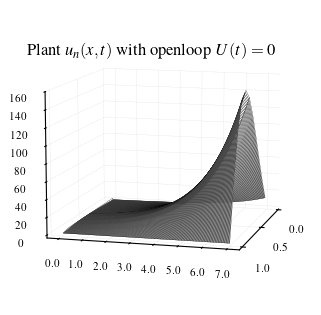

In [21]:
# 初始设置与图形创建
# fig = plt.figure(figsize=set_size(1024, 0.49, (1,2), height_add=0.5))
# subfigs = fig.subfigures(nrows=1, ncols=2, width_ratios=[1, 1], height_ratios=[1])
# subfig0 = subfigs[0]
# subfig1 = subfigs[1]
fig = plt.figure(figsize=set_size(522, 0.49, (1,1), height_add=0.5))
subfigs = fig.subfigures(nrows=1, ncols=1)
subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
subfig.suptitle(r"Plant $u_n(x, t)$ with openloop $U(t)=0$")
# subfig0.subplots_adjust(left=0.07, bottom=0, right=1, top=0.9)
# subfig1.subplots_adjust(left=0.15, bottom=0, right=1, top=0.9)
# subfig0.suptitle(r"Plant $u(x, t)$ with openloop $U(t)=0$")
# subfig0.suptitle(r"$\|\mathbf{u}(t,r)\|_{L^2}$")

axes0 = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
# axes0.set_title(r"Plant $u(x, t)$ with openloop $U(t)=0$")

for axis in [axes0.xaxis, axes0.yaxis, axes0.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(r, time1)
uopen = u.transpose()

                     
axes0.plot_surface(meshx, mesht, uopen, edgecolor="black",lw=0.2, rstride=50, cstride=5, alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes0.view_init(10, 15)
axes0.zaxis.set_rotate_label(False)
axes0.set_xticks([0, 0.5, 1])
axes0.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# axes1 = subfig1.subplots(nrows=1, ncols=1)
# # axes1.set_title(r"$\|\mathbf{u}(t,r)\|_{L^2}$")
# axes1.plot(time1, error, 'm.-', label='Error')
# axes1.set_xlabel('Time (sec)')
# axes1.set_ylabel(r'$|| \mathbf{u}(t,r) ||_{L^2}$')



# folder_path = r"F:\Program\MASs\simulate\code_radially_varying\code_radially_varying\un\result"
folder_path = r"E:\Python_Program\code_radially_varying\code_radially_varying\un\result"
os.makedirs(folder_path, exist_ok=True)
save_path = os.path.join(folder_path, "openloop.pdf")
plt.savefig(save_path, dpi=300)


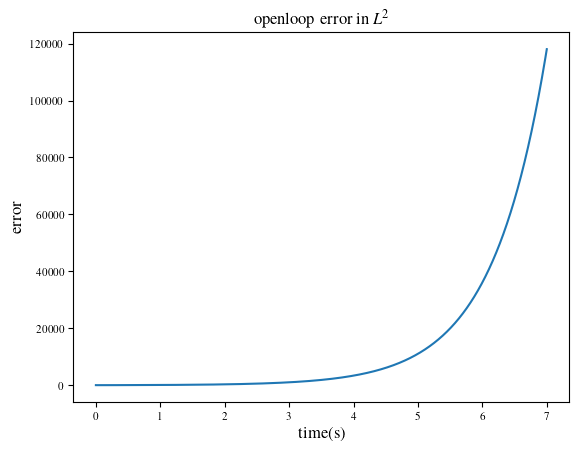

In [22]:
fig = plt.figure()
plt.plot(time1, error)
plt.xlabel('time(s)', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.title(r"openloop error in $L^2$")

# folder_path = r"F:\\Program\\MASs\\simulate\\code_radially_varying\\un\\result"
# os.makedirs(folder_path, exist_ok=True)
save_path = os.path.join(folder_path, "erro_L^2.pdf")
plt.savefig(save_path, dpi=300)